In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

Set *Axlmutants_Erl_F154* or *Axlmutants_Erl* to **True** in order to use these data.

In [3]:
ABC = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T
info = ABC.iloc[:, :7]

### Phenotypes

#### Cell Viability (from luminex...):

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv')
# Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/101819-CellTiterGlo_AxlMutants_F154_BR1_raw.csv').T

Y_cv = Y_cv.iloc[:, 0:10].div(Y_cv.iloc[:, 0], axis=0).T

# Y_cv = Y_cv.iloc[:, 0:10].sub(Y_cv.iloc[:, 0:10].mean(axis=1), axis=0).T

# Chained MS mixed clustering + PLSR analysis

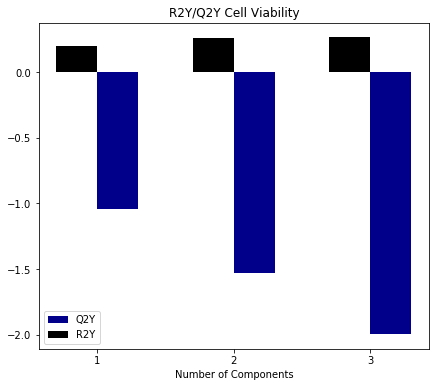

In [5]:
distance_method = "Binomial"
ncl = 3
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [7]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

In [8]:
# fig, ax = plt.subplots(1,1,figsize=(6,5))
# plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

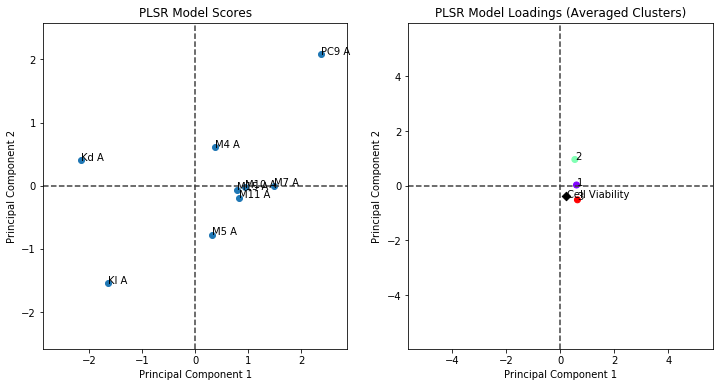

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [10]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,...,Pos_C2,r2/Std_C2,BioReps_C2,Prot_C3,abbv_C3,seqs_C3,UniprotAcc_C3,Pos_C3,r2/Std_C3,BioReps_C3
0,40S ribosomal protein SA,RPSA,LTEASyVNLPT,P08865,Y139-p,NA,1,Activated CDC42 kinase 1,TNK2,VKKPTyDPVSE,...,Y518-p,NA,1,Abl interactor 2,ABI2,VVPNDyVPSPT,Q9NYB9,Y213-p,NA,1
1,Adapter molecule crk,CRK,QEEAEyVRALF,P46108,Y136-p,NA,1,Afadin,AFDN,TYTREyFTFPA,...,Y1230-p,NA,1,Catenin delta-1,CTNND1,GGSDNyGSLSR,O60716,Y228-p,NA,1
2,Catenin delta-1,CTNND1,SRQDVyGPQPQ,O60716,Y257-p,NA,1,Alpha-actinin-1,ACTN1,DVAEKyLDIPK,...,Y215-p,NA,1,Cell surface glycoprotein MUC18,MCAM,DQGEKyIDLRH,P43121,Y641-p,NA,1
3,Crk-like protein,CRKL,RVPCAyDKTAL,P46109,Y251-p,NA,1,Annexin A2,ANXA2,GSVKAyTNFDA,...,Y30-p,NA,1,Clathrin heavy chain 1,CLTC,ITEEDyQALRT,Q00610,Y1477-p,NA,1
4,Desmoplakin,DSP,QPELKyGDGIQ,P15924,Y95-p,NA,1,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1",ARAP1,FDDSDyDEVPE,...,Y231-p,NA,1,Cysteine-rich protein 1,CRIP1,CNKEVyFAERV,P50238,Y12-p,NA,1
5,Eukaryotic translation initiation factor 2 subunit 2,EIF2S2,KDTRLyFLQCE,P20042,Y298-p,NA,1,BAG family molecular chaperone regulator 3,BAG3,AQQGEyQTHQP,...,Y240-p,NA,1,E3 ubiquitin-protein ligase CBL-B,CBLB,RtSQDyDQLPS,Q13191,Y889-p,NA,1
6,Filamin-B,FLNB,IDNYDySHTVK,O75369,Y904-p,NA,1,Band 4.1-like protein 1,EPB41L1,IRPGEyEQFES,...,Y343-p,NA,1,GRB2-associated-binding protein 1,GAB1,VDSSLyNLPRS,Q13480,Y259-p,NA,1
7,Filamin-B,FLNB,STETCySAIPK,O75369,Y2502-p,NA,1,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1,BAIAP2L1,VVRKDyDTLSK,...,Y274-p,NA,1,Glycogen synthase kinase-3 alpha,GSK3A,EPNVSyICSRY,P49840,Y279-p,NA,1
8,GRB2-associated-binding protein 2,GAB2,DNEDVyTFKTP,Q9UQC2,Y293-p,NA,1,Caveolin-1,CAV1,MSGGKyVDSEG,...,Y6-p,NA,1,Glycosaminoglycan xylosylkinase,FAM20B,VEGEPyAGYDR,O75063,Y138-p,NA,1
9,Heat shock protein HSP 90-beta,HSP90AB1,IVTSTyGWTAN,P08238,Y596-p,NA,1,Centrosomal protein of 89 kDa,CEP89,HSDDLyAVPHR,...,Y157-p,NA,1,Golgin subfamily A member 4,GOLGA4,YEKNVyATTVG,Q13439,Y2148-p,NA,1


In [11]:
create_download_link(clustermembers, "DataClustering")

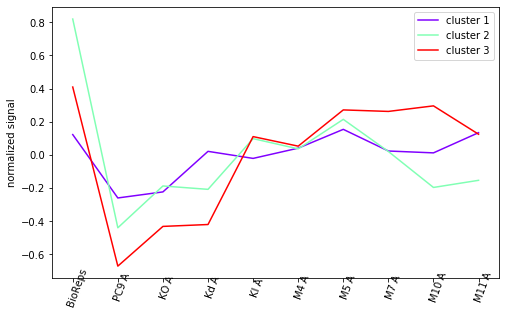

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, ncl)